# ABS Monthly Lending 5601

## Python set-up

In [9]:
# system imports
import sys

# analytic imports
import pandas as pd
import matplotlib.pyplot as plt

# local imports
from abs_data_capture import (
    get_fs_constants,
    get_ABS_meta_and_data,
    get_plot_constants,
    get_meta_constants,
)
from plotting import (
    finalise_plot,
    set_chart_dir,
    clear_chart_dir,
    recalibrate,
    seas_trend_plot,
    line_plot,
)

# pandas display settings
pd.options.display.max_rows = None
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 100

# display charts in this notebook
SHOW = False

## Get data from ABS

In [2]:
catalogue_id = "5601"
source, CHART_DIR, META_DATA = get_fs_constants(catalogue_id)

# The ABS has the data in multiple zip files, therefore
# this is a bit more complicated than what I usually do
abs_dict = {}
for url_num in [0, 1, 2, 3, 4, 5]:
    # get zip file and tables from ABS
    d = get_ABS_meta_and_data(catalogue_id, table=url_num, verbose=False)
    if d is None:
        sys.exit(-1)

    # handle meta data
    m = d[META_DATA]
    if META_DATA not in abs_dict:
        abs_dict[META_DATA] = m
    else:
        abs_dict[META_DATA] = pd.concat([abs_dict[META_DATA], m])
    del d[META_DATA]

    # handle xlsx files
    abs_dict = {**abs_dict, **d}

meta = abs_dict[META_DATA]
RECENT, plot_times, plot_tags = get_plot_constants(meta)
did_col, id_col, table_col, type_col, unit_col = get_meta_constants()

Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...
Found URL for a ZIP file on ABS web page
We need to download this file from the ABS ...
Saving ABS download to cache.
Extracting DataFrames from the zip-file ...


## Plotting

### Set-up

In [3]:
plt.style.use("fivethirtyeight")
clear_chart_dir(CHART_DIR)
set_chart_dir(CHART_DIR)

### Headline Indicators

In [4]:
def fix_title(title, lfooter):
    check = [
        "Total housing excluding refinancing",
        "Total purpose excluding refinancing",
        "New loan commitments",
        "Fixed term loans",
        "Value",
    ]
    for c in check:
        text = f"{c} ;"
        if text in title:
            title = title.replace(text, "")
            lfooter = lfooter + f"{c}. "
    title = (
        title.replace("Businesses", "")
        .replace("Business Finance", "Business Finance -")
        .replace("Households", "Households -")
        .replace(";", "")
        .replace("    ", " ")
        .replace("   ", " ")
        .replace("  ", " ")
        .strip()
    )
    return title, lfooter

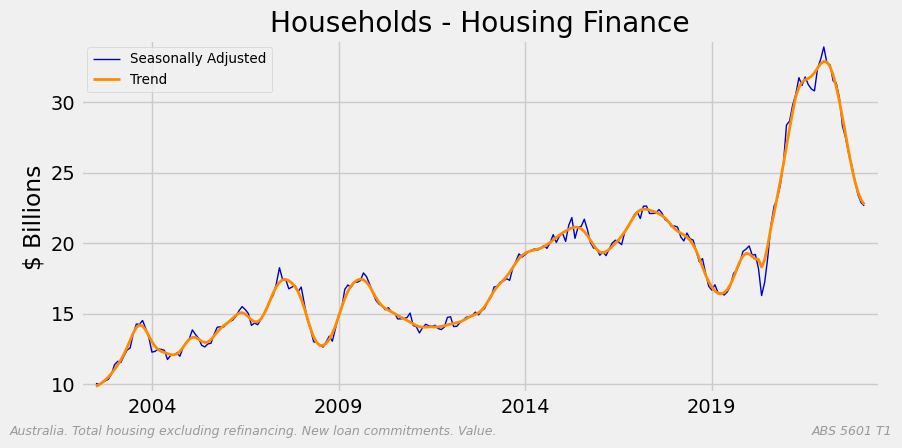

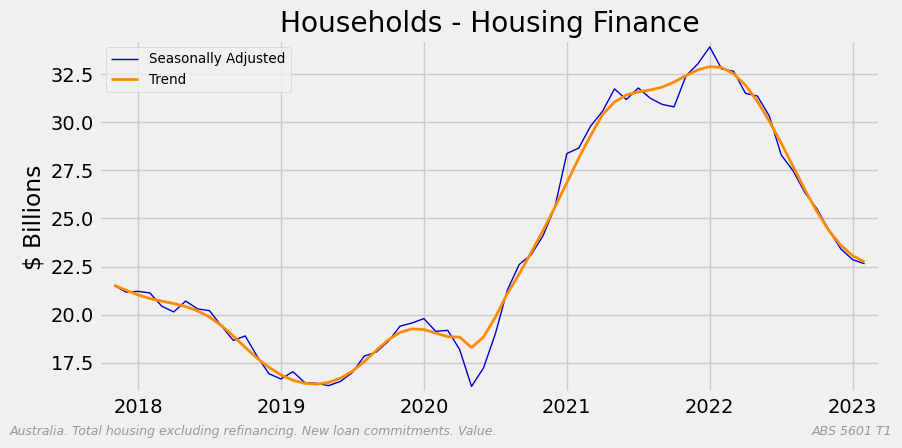

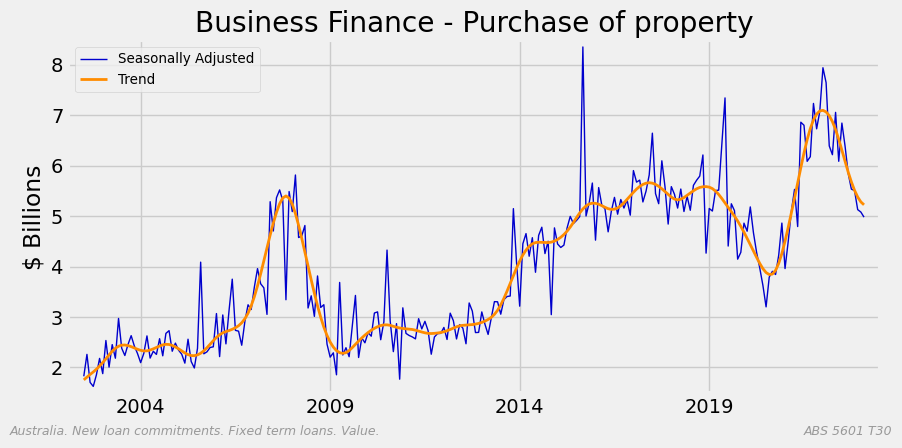

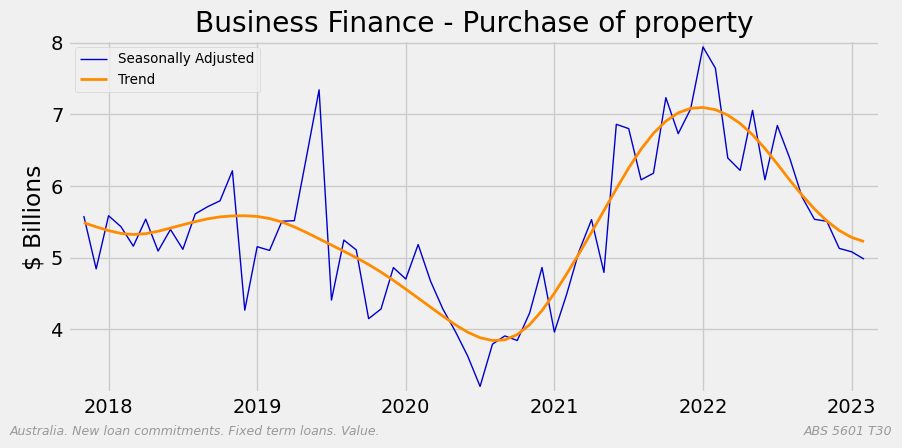

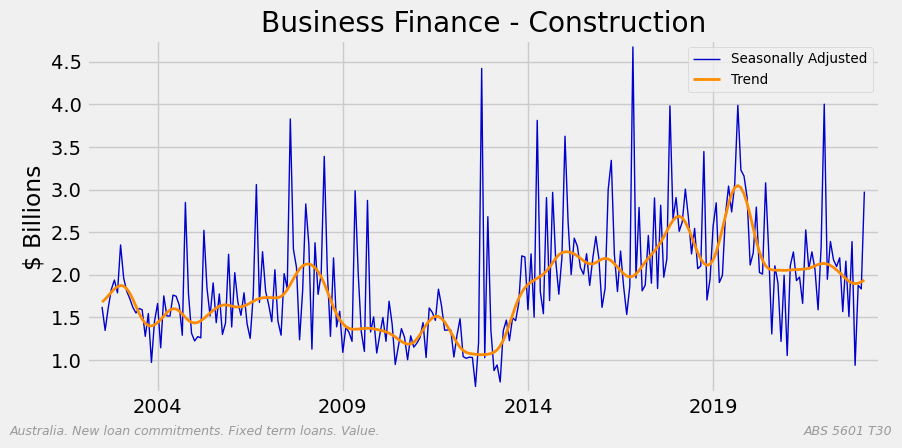

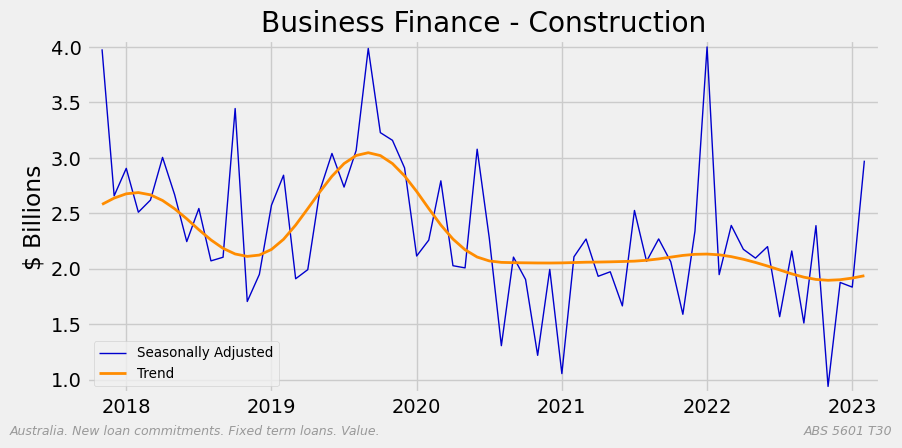

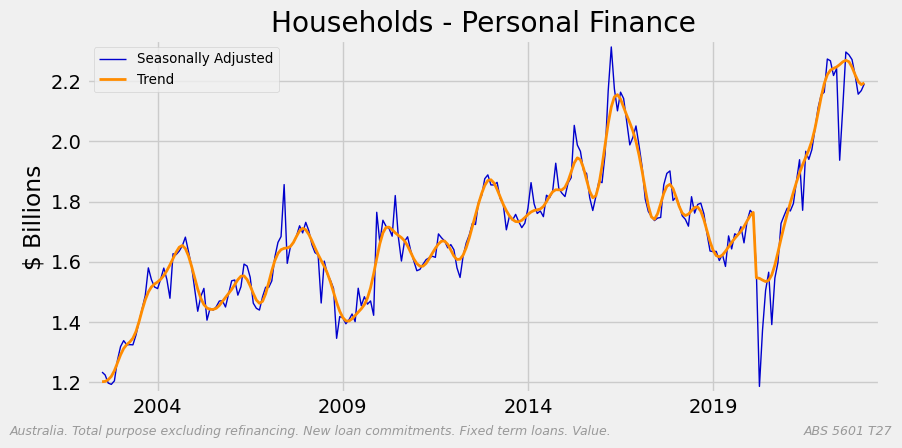

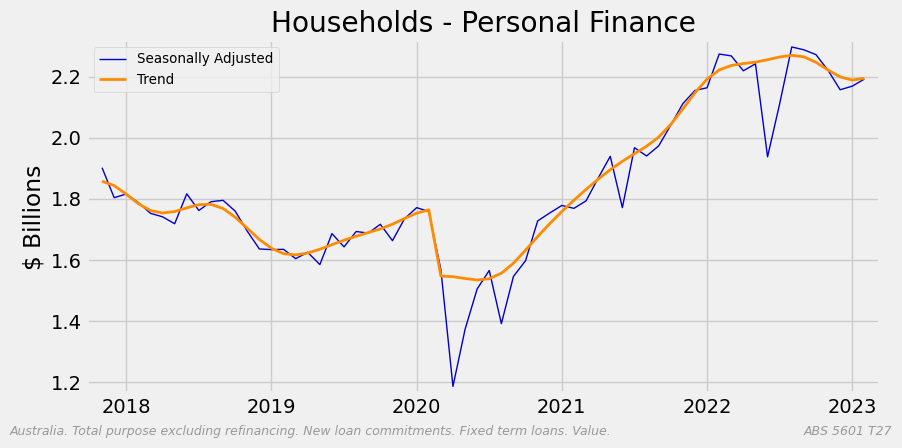

In [5]:
rows = [
    "Households ;  Housing Finance ;  Total housing excluding refinancing ;  New loan commitments ;",
    "Businesses ;  Business Finance ;  Fixed term loans ;  Purchase of property ;  New loan commitments ;",
    "Businesses ;  Business Finance ;  Fixed term loans ;  Construction ;  New loan commitments ;  Value ;",
    "Households ;  Personal Finance ;  Fixed term loans ;  Total purpose excluding refinancing ;  New loan commitments ;",
]

for headline in rows:
    # get data
    f = pd.DataFrame()
    for series_type in "Seasonally Adjusted", "Trend":
        found = meta[
            meta[type_col].str.contains(series_type)
            & meta[did_col].str.contains(headline)
        ]
        assert len(found) == 1
        row = found.iloc[0]
        series_id, units, table, did = (
            row[id_col],
            row[unit_col],
            row[table_col],
            row[did_col],
        )
        f[series_type] = abs_dict[table][series_id]
    f, units = recalibrate(f, units)

    # plot
    title, lfooter = fix_title(did, "Australia. ")
    seas_trend_plot(
        f,
        starts=plot_times,
        tags=plot_tags,
        title=title,
        ylabel=f"{units}",
        lfooter=lfooter,
        rfooter=f"{source} T{table}",
        show=SHOW,
    )

### Business

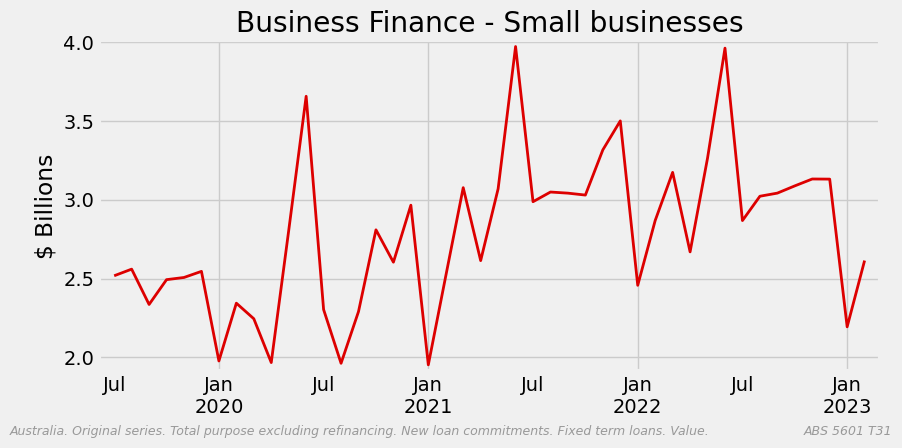

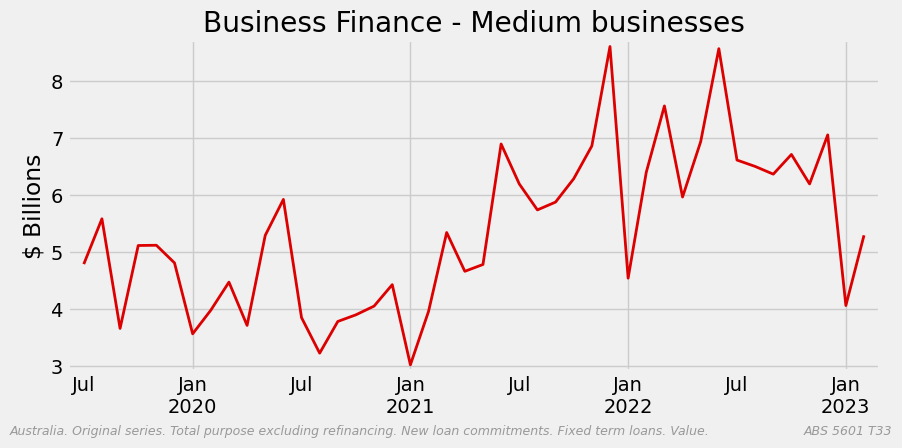

In [6]:
rows = meta[
    meta[did_col].str.contains("Business")
    & meta[did_col].str.contains("loans")
    & meta[did_col].str.contains("Total purpose")
]
for index, row in rows.iterrows():
    series_id, units, table, did, series_type = (
        row[id_col],
        row[unit_col],
        row[table_col],
        row[did_col],
        row[type_col],
    )
    series, units = recalibrate(abs_dict[table][series_id], units)
    title, lfooter = fix_title(did, f"Australia. {series_type} series. ")
    title = title.replace("Businesses", "").strip()
    line_plot(
        series,
        title=title,
        ylabel=f"{units}",
        lfooter=lfooter,
        rfooter=f"{source} T{table}",
        show=SHOW,
    )

## Finished

In [7]:
# watermark
%load_ext watermark
%watermark -u -n -t -v -iv -w

Last updated: Tue Apr 04 2023 08:36:12

Python implementation: CPython
Python version       : 3.11.2
IPython version      : 8.12.0

matplotlib: 3.7.1
pandas    : 2.0.0
sys       : 3.11.2 | packaged by conda-forge | (main, Mar 31 2023, 17:54:27) [Clang 14.0.6 ]

Watermark: 2.3.1



In [8]:
print("Done")

Done
